#  Road Condition Detection CNN

## Imports

In [3]:
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator

In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

## Setting directory paths

In [5]:
base_dir = r"/Pothole-and-Plain-Road-Classification-main/archive/My Dataset"

In [10]:

train_dir = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\archive\My Dataset\train'
test_dir = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\archive\My Dataset\test'
validation_dir = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\archive\My Dataset\validation'

In [11]:


train_plain_dir = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\archive\My Dataset\train\plain'
train_pothole_dir = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\archive\My Dataset\train\pothole'

In [12]:

test_plain_dir = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\archive\My Dataset\test\plain'
test_pothole_dir = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\archive\My Dataset\test\pothole'

In [13]:

validation_plain_dir = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\archive\My Dataset\validation\plain'
validation_pothole_dir = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\archive\My Dataset\validation\pothole'

In [14]:
# Sanity checks
print('total training plain images :', len(os.listdir(train_plain_dir)))
print('total training pothole images : ',len(os.listdir(train_pothole_dir)))
print('total validation plain images :', len(os.listdir(validation_plain_dir)))
print('total validation pothole images :', len(os.listdir(validation_pothole_dir)))
print('total test plain images :', len(os.listdir(test_plain_dir)))
print('total test pothole images :', len(os.listdir(test_pothole_dir)))

total training plain images : 210
total training pothole images :  211
total validation plain images : 70
total validation pothole images : 70
total test plain images : 70
total test pothole images : 70


## Re-scaling images to 224 X 224 to match VGG16 input size

In [15]:
train_size, validation_size, test_size = 420,140,140
img_width, img_height = 224, 224

13.1733149.jpg


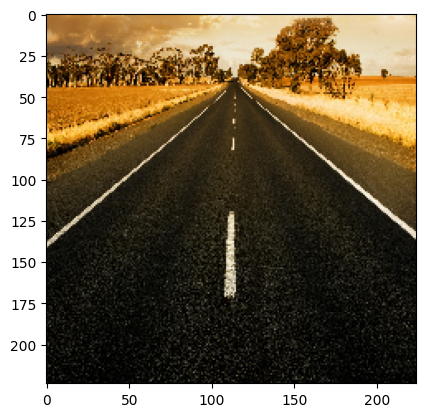

189.pothole-london.jpg


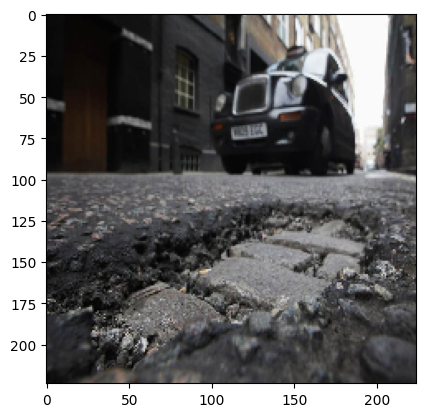

97.b6d690f129694c2d824c5979fca7ad33.gif


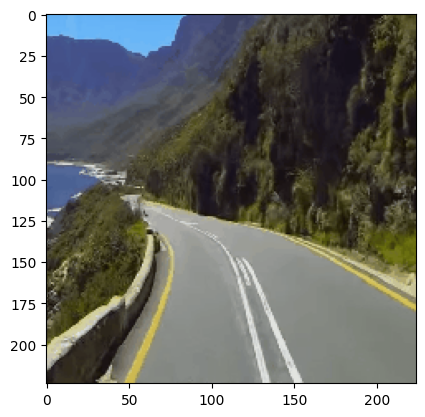

16.potholes010.jpg


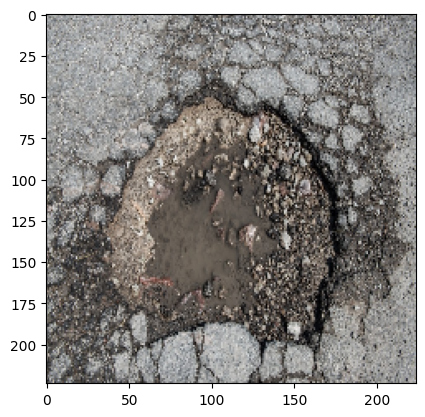

In [34]:
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)
    print(random_img)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_plain_dir)
    show_pictures(train_pothole_dir)

## Obtaining the pre-trained weights from VGG16 for the Convolutional Base

In [17]:
from keras.applications import VGG16

# Input Shape: (224 X 224 X 3) where 3 is the number of input color channels, RGB
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

In [18]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Loading Dataset

In [19]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    #features = np.zeros(shape=(32, 7, 7, 512))  # Must be equal to the output of the convolutional base
    features = np.zeros(shape=(sample_count, 7, 7, 512))

    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    #i = 0
    #for inputs_batch, labels_batch in generator:
     #   features_batch = conv_base.predict(inputs_batch)
      #  features[i * batch_size: (i + 1) * batch_size] = features_batch
       # labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        #i += 1

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1

        if i * batch_size >= sample_count:
            break

    return features, labels
   
 
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 420 images belonging to 2 classes.
1/1 [==============================] - 7s 7s/step


C:\Users\hp\Pothole-and-Plain-Road-Classification-main\venv\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 1s 1s/step
Found 140 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Found 140 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step


In [21]:
# Debug
print(train_features)
print(train_labels)

[[[[9.37130511e-01 0.00000000e+00 4.72039938e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.00493515e-01 ... 0.00000000e+00
    4.32051659e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    8.38926554e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 3.16973001e-01 ... 0.00000000e+00
    4.97441769e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.98528618e-01 ... 0.00000000e+00
    4.42505598e-01 0.00000000e+00]
   [1.46114200e-01 0.00000000e+00 2.47874916e-01 ... 0.00000000e+00
    1.09778583e-01 0.00000000e+00]]

  [[9.27258372e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.28837597e-01 0.00000000e+00]
   [2.66188383e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    2.19415843e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.91551542e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 3.59807730e-01 ... 0.00

In [22]:
train_features.shape

(420, 7, 7, 512)

## Classifier1: Fully Connected Layer Model

In [23]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6423041 (24.50 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [25]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100


14/14 [==============================] - 5s 122ms/step - loss: 0.8645 - acc: 0.7881 - val_loss: 0.3044 - val_acc: 0.8857
Epoch 2/100
14/14 [==============================] - 1s 81ms/step - loss: 0.3188 - acc: 0.9119 - val_loss: 0.3270 - val_acc: 0.8786
Epoch 3/100
14/14 [==============================] - 1s 78ms/step - loss: 0.1516 - acc: 0.9524 - val_loss: 0.1378 - val_acc: 0.9500
Epoch 4/100
14/14 [==============================] - 1s 77ms/step - loss: 0.0803 - acc: 0.9786 - val_loss: 0.0187 - val_acc: 0.9857
Epoch 5/100
14/14 [==============================] - 1s 82ms/step - loss: 0.0422 - acc: 0.9833 - val_loss: 0.0160 - val_acc: 0.9929
Epoch 6/100
14/14 [==============================] - 1s 80ms/step - loss: 0.0182 - acc: 0.9976 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 7/100
14/14 [==============================] - 1s 83ms/step - loss: 0.0151 - acc: 0.9929 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 8/100
14/14 [==============================] - 1s 83ms/step - loss:

In [26]:
# Save model
#model.save('pothole_fcl.h5')
model.save('pothole_fcl.keras')

In [56]:
# from tensorflow import keras
# # Load model
# model = keras.models.load_model('pothole_fcl.h5')

### Classifier1: Fully Connected Layer Model Evaluation

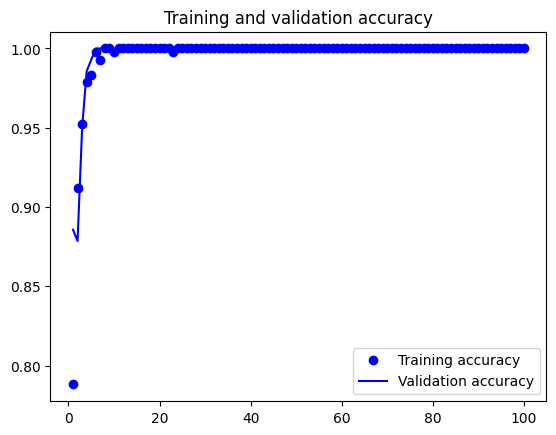

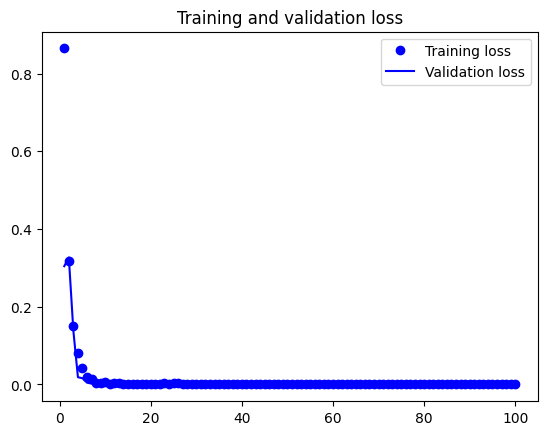

In [27]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Classifier1: Fully Connected Layer Model in Action

In [28]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_plain_dir, test_pothole_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Plain')
        else:
            print('Pothole')

1/1 [==============================] - 0s 85ms/step


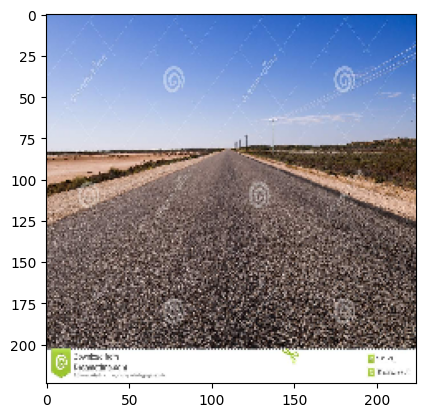

Plain
1/1 [==============================] - 0s 75ms/step


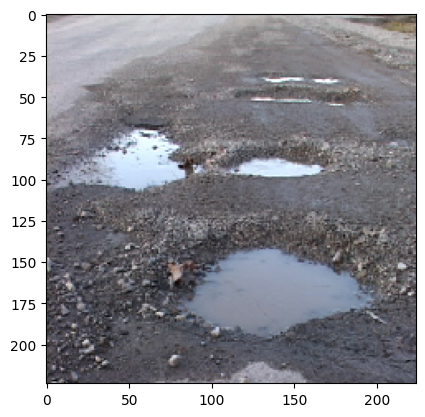

Pothole
1/1 [==============================] - 0s 65ms/step


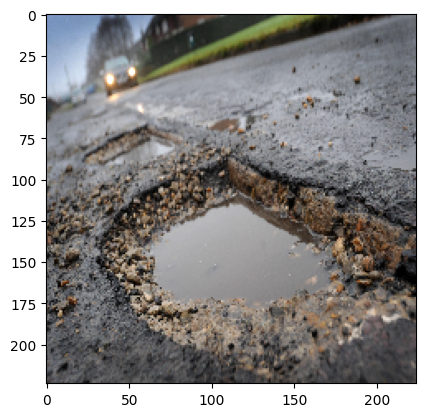

Pothole
1/1 [==============================] - 0s 79ms/step


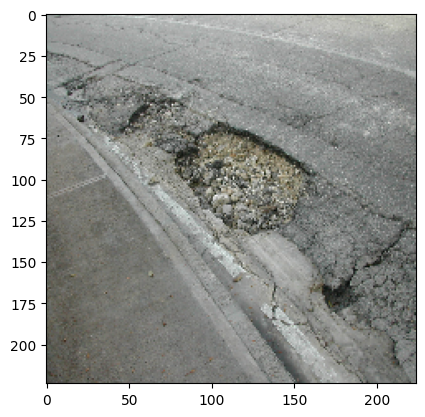

Pothole
1/1 [==============================] - 0s 65ms/step


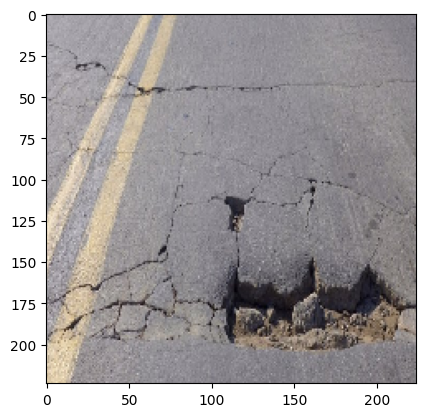

Pothole


In [29]:
# Visualize predictions
visualize_predictions(model, 5)

### Classifier1: Fully Connected Layer Model Performance Metrics

In [30]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7, 7, 512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(model)


1/1 [==============================] - 0s 63ms/step


In [5]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Function to classify a specific uploaded image
def classify_uploaded_image(model, img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    # Extract features using the pre-trained convolutional base
    features = conv_base.predict(img_tensor)

    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 7*7*512))

    # Display the image
    plt.imshow(img_tensor[0])
    plt.show()

    # Display the prediction
    if prediction < 0.5:
        print('Plain')
    else:
        print('Pothole')

# Example usage:
# Specify the path to the uploaded image
uploaded_image_path = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\upload\10.jpg'

# Call the function to classify the uploaded image
classify_uploaded_image(model, uploaded_image_path)


NameError: name 'model' is not defined

Confusion Matrix: 
[[67  3]
 [ 2 68]]
Accuracy:  0.9642857142857143
Specificity:  0.9571428571428572
Precision/Positive Predictive Value:  0.9577464788732394
Negative Predictive Value:  0.9710144927536232
Recall/Sensitivity:  0.9714285714285714
False Positive Rate:  0.6
False Negative Rate:  0.02857142857142857
Positive Likelihood Ratio:  1.619047619047619
Negative Likelihod Ratio:  0.029850746268656716
Diagnostic Odds Ratio:  54.23809523809524
False Omission Rate:  0.028985507246376812
F1 Score:  0.9645390070921985
Area under ROC curve:  0.9642857142857144


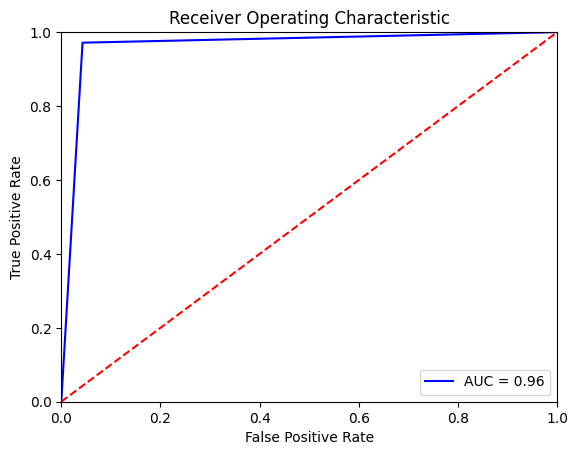

In [34]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
import cv2
import numpy as np

def detect_pothole_area(image_path):
    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Unable to read the image at {image_path}")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and help contour detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to store the area of potholes
    pothole_area = 0

    # Loop over the contours
    for contour in contours:
        # Calculate the area of the contour
        area = cv2.contourArea(contour)

        # Set a threshold for the area to filter out small contours (adjust as needed)
        if area > 100:
            pothole_area += area

            # Draw the contour on the original image
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)

    if pothole_area > 0:
        # Display the image with contours
        cv2.imshow('Pothole Detection', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("No potholes detected in the provided image.")

    return pothole_area

# Example usage

image_path = r'C:\Users\hp\Pothole-and-Plain-Road-Classification-main\upload\10.jpg'
pothole_area = detect_pothole_area(image_path)
print(f'Pothole Area: {pothole_area} square pixels')




## Classifier2: Global Average Pooling Model


In [62]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [64]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
14/14 [==============================] - 1s 24ms/step - loss: 0.7153 - acc: 0.4762 - val_loss: 0.6920 - val_acc: 0.5214
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 0.6657 - acc: 0.6452 - val_loss: 0.6531 - val_acc: 0.7143
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 0.6285 - acc: 0.8024 - val_loss: 0.6186 - val_acc: 0.7714
Epoch 4/100
14/14 [==============================] - 0s 10ms/step - loss: 0.5943 - acc: 0.8333 - val_loss: 0.5880 - val_acc: 0.7929
Epoch 5/100
14/14 [==============================] - 0s 10ms/step - loss: 0.5670 - acc: 0.8476 - val_loss: 0.5626 - val_acc: 0.8143
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5396 - acc: 0.8667 - val_loss: 0.5388 - val_acc: 0.7929
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5166 - acc: 0.8714 - val_loss: 0.5164 - val_acc: 0.8214
Epoch 8/100
14/14 [==============================] - 0s 6ms/step - loss: 0.4956 

In [66]:
# Save model
#model.save('pothole_gap.h5')
model.save('pothole_gap.keras')

In [67]:
# from tensorflow import keras
# # Load model
# model = keras.models.load_model('pothole_gap.h5')

### Classifier2: Global Average Pooling Model Evaluation

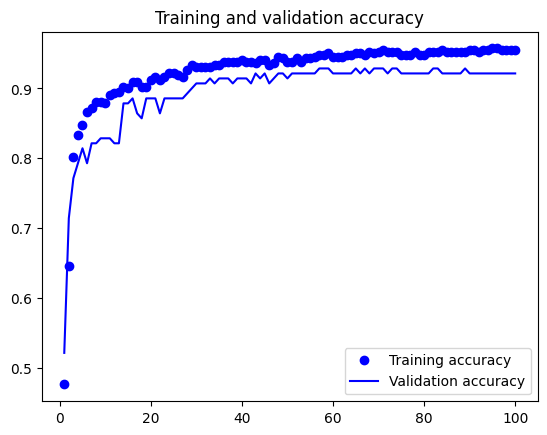

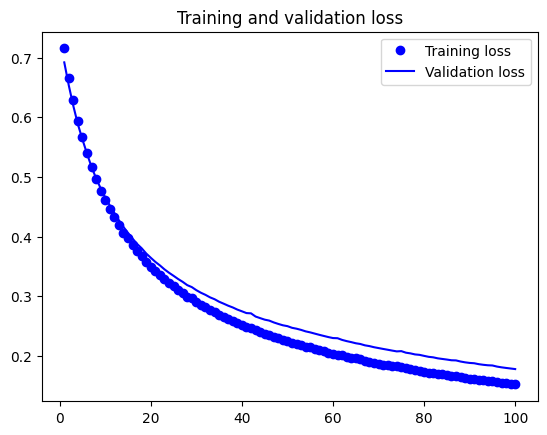

In [68]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Classifier2: Global Average Pooling Model in Action

1/1 [==============================] - 0s 53ms/step


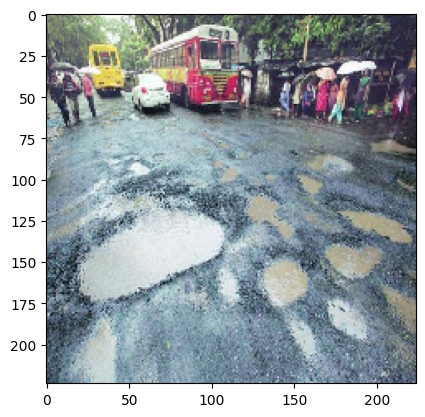

Pothole
1/1 [==============================] - 0s 41ms/step


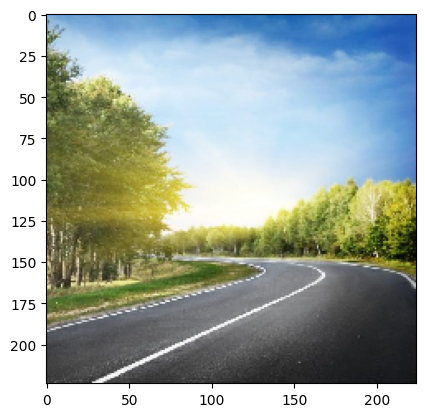

Plain
1/1 [==============================] - 0s 20ms/step


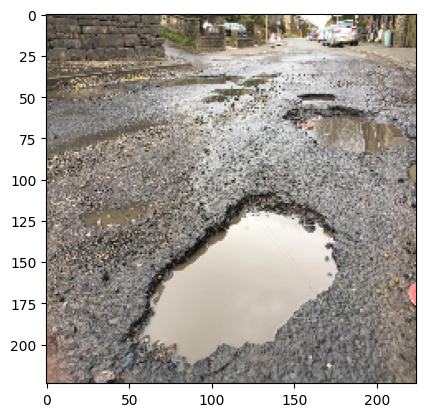

Pothole
1/1 [==============================] - 0s 32ms/step


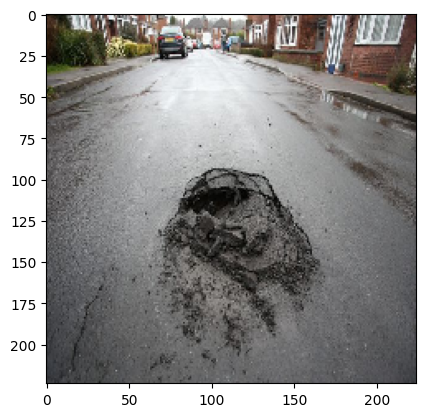

Pothole
1/1 [==============================] - 0s 19ms/step


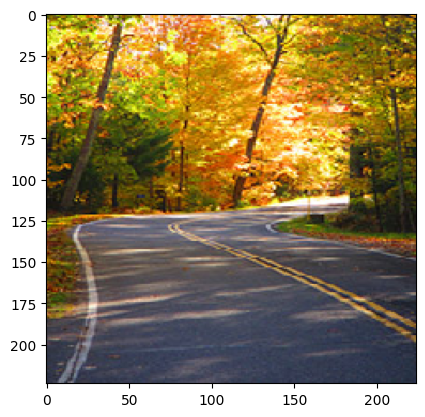

Plain


In [69]:
# Visualize predictions
visualize_predictions(model, 5)

### Classifier2: Global Average Pooling Model Performance Metrics

In [70]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7, 7, 512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(model)


1/1 [==============================] - 0s 29ms/step


Confusion Matrix: 
[[66  4]
 [ 3 67]]
Accuracy:  0.95
Specificity:  0.9428571428571428
Precision/Positive Predictive Value:  0.9436619718309859
Negative Predictive Value:  0.9565217391304348
Recall/Sensitivity:  0.9571428571428572
False Positive Rate:  0.5714285714285714
False Negative Rate:  0.04285714285714286
Positive Likelihood Ratio:  1.6750000000000003
Negative Likelihod Ratio:  0.045454545454545456
Diagnostic Odds Ratio:  36.85
False Omission Rate:  0.043478260869565216
F1 Score:  0.9503546099290779
Area under ROC curve:  0.9500000000000001


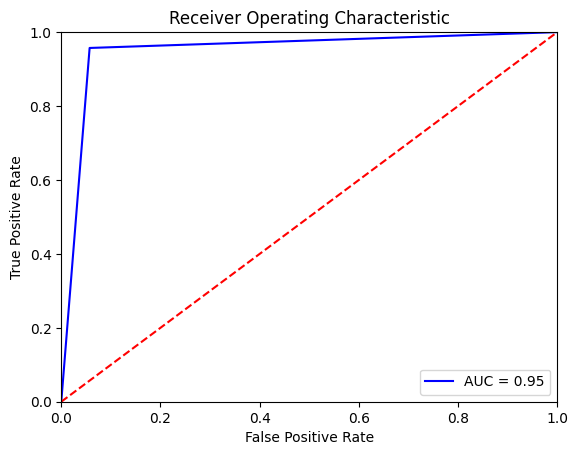

In [71]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Classifier3: Linear Support Vector Machine Model
### Model Definition

In [ ]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [73]:
svm_labels

array([0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 0., 1.

In [74]:
svm_features.shape

(560, 7, 7, 512)

In [76]:
# Build model
'''
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(560,7*7*512), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge',max_iter=10000)  # As in Tang (2013)
#svm_model = SVC(dual=False)  # Set dual parameter explicitly

clf = GridSearchCV(svm, param, cv=10,verbose=10)
clf.fit(X_train, y_train)
'''

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Create a sample dataset (replace this with your actual data)
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Define the SVM model
svm_model = SVC()

# Define the parameter grid for grid search
param_grid = {'C': [0.01, 0.1, 1.0, 10.0, 100.0]}

# Create a GridSearchCV object
grid_search = GridSearchCV(svm_model, param_grid, cv=10)

# Perform the grid search
grid_search.fit(X, y)


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]})

In [77]:
# Save model
import joblib
joblib.dump(clf, 'pothole_svm.pkl')

['pothole_svm.pkl']

In [78]:
# Load model
# clf = joblib.load('pothole_svm.h5')

In [79]:
clf

GridSearchCV(cv=10, estimator=LinearSVC(max_iter=10000),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}], verbose=10)

### Classifier3: Linear Support Vector Machine Model Evaluation

In [ ]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#clf = SVC(C=0.01, dual=False)
print("\nAccuracy score (mean):")
acc_mean = np.mean(cross_val_score(clf, X_train, y_train, cv=10,verbose=10))
# print(cvss)
#print("\nAccuracy score (mean):")
#acc_mean = np.mean(cross_val_score(clf, X_train, y_train, cv=10, verbose=10))

print("\nAccuracy score (standard deviation):")
acc_std = np.std(cross_val_score(clf, X_train, y_train, cv=10,verbose=10))
# print(asss)

#print("\nAccuracy score (standard deviation):")
#acc_std = np.std(cross_val_score(clf, X_train, y_train, cv=10, verbose=10))

In [ ]:
print("Accuracy score (mean) :", acc_mean)
print("\nAccuracy score (standard deviation) :", acc_std)

In [ ]:
# Plot learning curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                        X = X_train,
                                                        y = y_train,
                                                        train_sizes = np.linspace(0.1,1.0,10),
                                                        cv = 10,verbose=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   3.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=  13.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=  23.7s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   4.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=  13.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   7.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 6/10; 3/5] END ......................................C=1; total time=  31.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=  23.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=  17.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 6/10; 3/5] END ......................................C=1; total time=  34.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=  15.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   5.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=  11.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/10; 3/5] END ......................................C=1; total time=  39.7s
[CV 3/10; 3/5] START C=1........................................................
[CV 3/10; 3/5] END ......................................C=1; total time=   2.3s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=   3.9s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   2.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END .........

[CV 2/10; 3/5] END ......................................C=1; total time=   1.7s
[CV 3/10; 3/5] START C=1........................................................
[CV 3/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=  18.8s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=  18.3s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.6s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.8s
[CV 8/10; 3/5] START C=1........................................................


/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 8/10; 3/5] END ......................................C=1; total time=  35.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 10/10; 3/5] START C=1.......................................................


/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 10/10; 3/5] END .....................................C=1; total time=  37.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   3.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.8s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   1.9s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   1.6s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 7/10; 3/5] END ......................................C=1; total time=  35.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=  20.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   3.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=  29.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   5.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 7/10; 3/5] END ......................................C=1; total time=  34.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=  27.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=  16.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 136.6min finished


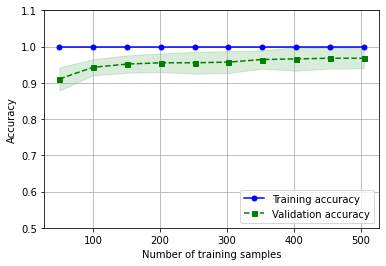

In [45]:
plt.plot(train_sizes, train_mean, color='blue', 
         marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.1])
plt.show()

### Classifier3: Linear Support Vector Machine Model in Action

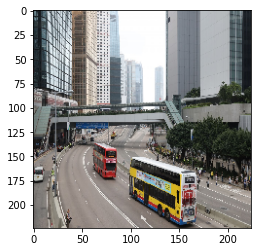

Plain


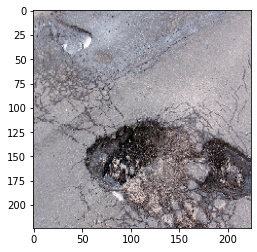

Pothole


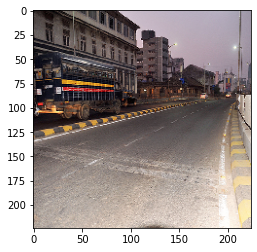

Plain


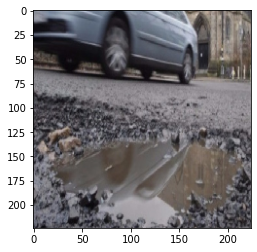

Pothole


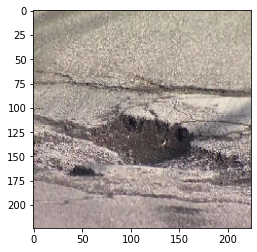

Pothole


In [46]:
# Visualize predictions
visualize_predictions(clf, 5)

### Classifier3: Linear Support Vector Machine Model Performance Metrics

In [47]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7*7*512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(clf)


Confusion Matrix: 
[[68  2]
 [ 3 67]]
Accuracy:  0.9642857142857143
Specificity:  0.9714285714285714
Precision/Positive Predictive Value:  0.9710144927536232
Negative Predictive Value:  0.9577464788732394
Recall/Sensitivity:  0.9571428571428572
False Positive Rate:  0.4
False Negative Rate:  0.04285714285714286
Positive Likelihood Ratio:  2.392857142857143
Negative Likelihod Ratio:  0.04411764705882353
Diagnostic Odds Ratio:  54.238095238095234
False Omission Rate:  0.04225352112676056
F1 Score:  0.9640287769784173
Area under ROC curve:  0.9642857142857144


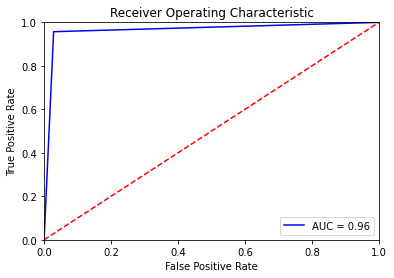

In [48]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()